# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Modelling
5. Hyperparameter Tuning
6. Evaluation


# SET-UP

## Import Library

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
import time
warnings.filterwarnings("ignore")

#EDA
from tabulate import tabulate
# ouliers
from scipy import stats
# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, classification_report,confusion_matrix, accuracy_score, mean_absolute_error, r2_score

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [2]:
# data_final = pd.read_csv("dataset/BTC-USD.csv")
# data_final = pd.read_csv("dataset/ETH-USD.csv")
# data_final = pd.read_csv("dataset/BNB-USD.csv")
data_final = pd.read_csv("dataset/SOL-USD.csv")
# data_final = pd.read_csv("dataset/XRP-USD.csv")

# EDA

In [3]:
# Read Data
data_final

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,1.509775,1.859656,1.502038,1.842084,1.842084,25722549
1,2021-01-02,1.845586,1.989295,1.721482,1.799275,1.799275,31671064
2,2021-01-03,1.799902,2.364981,1.799902,2.161752,2.161752,55073422
3,2021-01-04,2.162412,2.485097,1.876342,2.485097,2.485097,59955405
4,2021-01-05,2.490982,2.502616,2.077742,2.157217,2.157217,50555207
...,...,...,...,...,...,...,...
1090,2023-12-27,112.654831,115.033875,105.425232,107.023796,107.023796,4267938569
1091,2023-12-28,107.022705,109.420654,97.668648,102.104568,102.104568,4492625126
1092,2023-12-29,102.069283,109.671120,100.055511,106.311516,106.311516,4445797973
1093,2023-12-30,106.298500,107.328224,101.068123,101.845085,101.845085,1863177830


In [4]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1095.0,5.571583e+01,5.528422e+01,1.509775e+00,2.092022e+01,3.246004e+01,7.367156e+01,2.587816e+02
High,1095.0,5.832418e+01,5.766011e+01,1.859656e+00,2.146382e+01,3.369322e+01,7.749159e+01,2.600621e+02
Low,1095.0,5.316969e+01,5.261448e+01,1.502038e+00,2.034129e+01,3.112713e+01,7.124562e+01,2.461224e+02
Close,1095.0,5.578247e+01,5.522162e+01,1.799275e+00,2.092633e+01,3.246530e+01,7.405168e+01,2.589343e+02
Adj Close,1095.0,5.578247e+01,5.522162e+01,1.799275e+00,2.092633e+01,3.246530e+01,7.405168e+01,2.589343e+02
Volume,1095.0,1.309630e+09,1.435469e+09,2.572255e+07,3.574910e+08,8.516808e+08,1.823108e+09,1.706864e+10


In [5]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1095 non-null   object 
 1   Open       1095 non-null   float64
 2   High       1095 non-null   float64
 3   Low        1095 non-null   float64
 4   Close      1095 non-null   float64
 5   Adj Close  1095 non-null   float64
 6   Volume     1095 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


In [6]:
#drop feature that not used in this analysis ( 'Open', 'High', 'Low', 'Adj Close', 'Volume')
data_final = data_final.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data_final

,Date,Close
0,2021-01-01,1.842084
1,2021-01-02,1.799275
2,2021-01-03,2.161752
3,2021-01-04,2.485097
4,2021-01-05,2.157217
...,...,...
1090,2023-12-27,107.023796
1091,2023-12-28,102.104568
1092,2023-12-29,106.311516
1093,2023-12-30,101.845085


In [7]:
# Data Type Conversion
# Convert 'Date' to datetime if not already done
data_final['Date'] = pd.to_datetime(data_final['Date'])

#Feature Engineering
#Extract date parts
data_final['year'] = data_final['Date'].dt.year
data_final['month'] = data_final['Date'].dt.month
data_final['day'] = data_final['Date'].dt.day

data_final


,Date,Close,year,month,day
0,2021-01-01,1.842084,2021,1,1
1,2021-01-02,1.799275,2021,1,2
2,2021-01-03,2.161752,2021,1,3
3,2021-01-04,2.485097,2021,1,4
4,2021-01-05,2.157217,2021,1,5
...,...,...,...,...,...
1090,2023-12-27,107.023796,2023,12,27
1091,2023-12-28,102.104568,2023,12,28
1092,2023-12-29,106.311516,2023,12,29
1093,2023-12-30,101.845085,2023,12,30


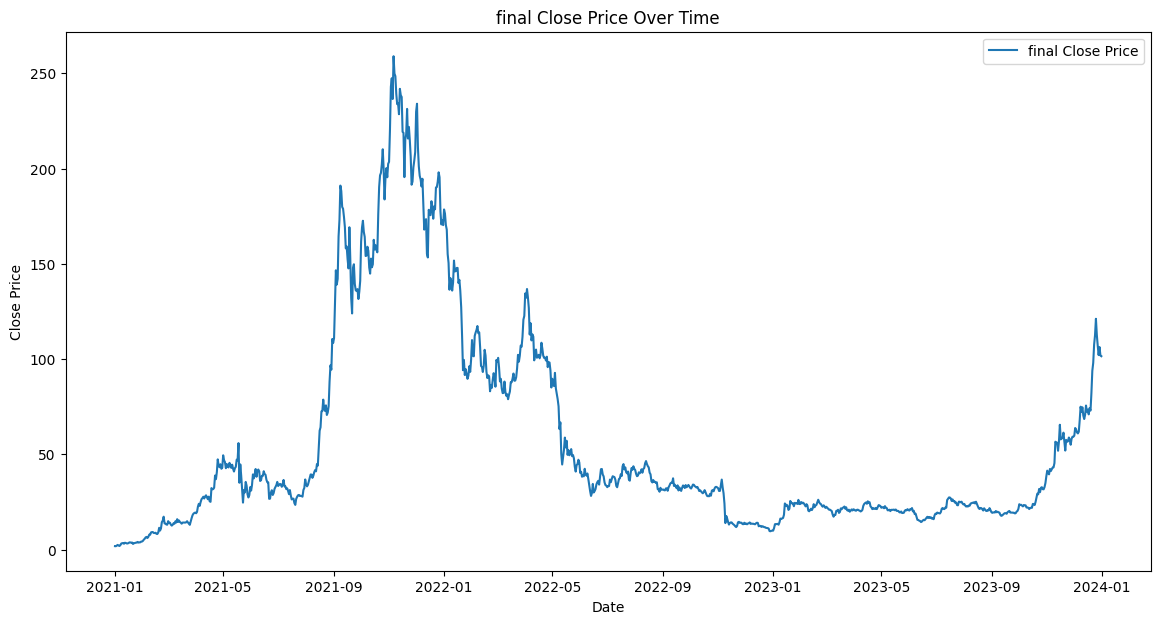

In [8]:
# visualisasi data close price / day
data_final.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(data_final['Close'], label='final Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('final Close Price Over Time')
plt.legend()
plt.show()


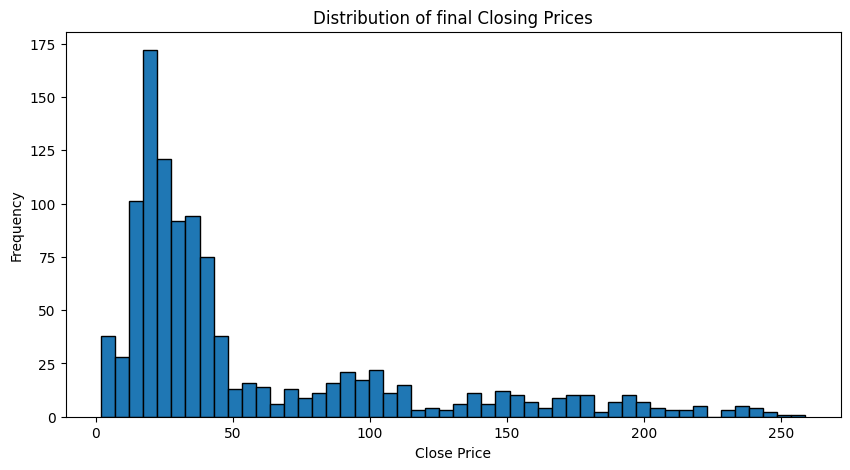

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(data_final['Close'], bins=50, edgecolor='k')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of final Closing Prices')
plt.show()


<Figure size 1200x600 with 0 Axes>

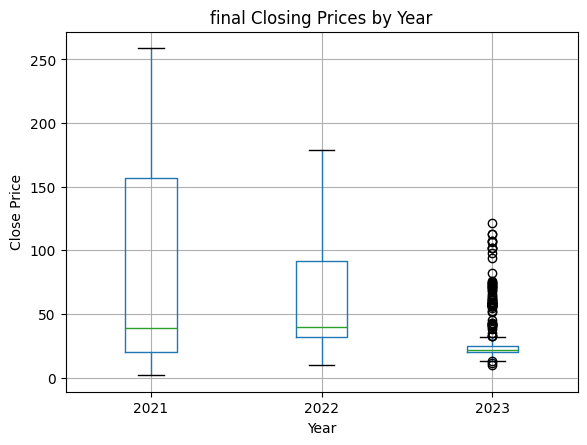

In [10]:
data_final['Year'] = data_final.index.year

plt.figure(figsize=(12, 6))
data_final.boxplot(column='Close', by='Year')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('final Closing Prices by Year')
plt.suptitle('')  # Suppress the automatic title
plt.show()

# DATA PREPROCESSING

Steps for Data Preprocessing:
1. Handling Missing Values 
2. Handling Duplicates 
3. Data Type Conversion ✅
4. Feature Engineering ✅
5. Normalization/Scaling (Tidak dilakukan karena model-model ini biasanya bekerja dengan data mentah)
6. Handling Outliers

In [11]:
# Check for missing values
data_final.isnull().sum()

Close    0
year     0
month    0
day      0
Year     0
dtype: int64

In [12]:
# Check for duplicates
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
drop = data_final.drop_duplicates()
print(f"Data setelah dihapus duplikat memiliki: {drop.shape[0]} baris dan {drop.shape[1]} kolom")

Data memiliki 1095 baris dan 5 kolom
Data setelah dihapus duplikat memiliki: 1095 baris dan 5 kolom


In [13]:
# Menghitung Z-Score untuk kolom 'Close'
z_scores = np.abs(stats.zscore(data_final[['Close']]))

# Mengidentifikasi outlier (Z-Score > 3)
outlier_mask = (z_scores > 3).any(axis=1)

# Membuat kolom baru 'Close_interpolated' yang berisi data tanpa outlier
data_final['Close_interpolated'] = data_final['Close'].copy()

# Mengisi nilai outlier dengan interpolasi linear pada kolom 'Close_interpolated'
data_final.loc[outlier_mask, 'Close_interpolated'] = np.nan
data_final['Close_interpolated'].interpolate(method='linear', limit_direction='both', inplace=True)

# Menampilkan DataFrame yang telah diperbarui
print(data_final['Close_interpolated'])

Date
2021-01-01      1.842084
2021-01-02      1.799275
2021-01-03      2.161752
2021-01-04      2.485097
2021-01-05      2.157217
                 ...    
2023-12-27    107.023796
2023-12-28    102.104568
2023-12-29    106.311516
2023-12-30    101.845085
2023-12-31    101.505821
Name: Close_interpolated, Length: 1095, dtype: float64


In [14]:
# Melihat jumlah nilai yang hilang di setiap kolom
print(data_final.isnull().sum())

# Atau, melihat lokasi nilai yang hilang
print(data_final[data_final.isnull().any(axis=1)])

Close                 0
year                  0
month                 0
day                   0
Year                  0
Close_interpolated    0
dtype: int64
Empty DataFrame
Columns: [Close, year, month, day, Year, Close_interpolated]
Index: []


In [15]:
# Check Descriptive Statistic
print("\n\n")
print("Check Descriptive Statistic")
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
data_final.describe().style.format("{:,.0f}")




Check Descriptive Statistic
Data memiliki 1095 baris dan 6 kolom


,Close,year,month,day,Year,Close_interpolated
count,"1,095","1,095","1,095","1,095","1,095","1,095"
mean,56,"2,022",7,16,"2,022",55
std,55,1,3,9,1,54
min,2,"2,021",1,1,"2,021",2
25%,21,"2,021",4,8,"2,021",21
50%,32,"2,022",7,16,"2,022",32
75%,74,"2,023",10,23,"2,023",74
max,259,"2,023",12,31,"2,023",220


In [16]:
# Split train - test data
train_size = int(len(data_final) * 0.8)
train_final, test_final = data_final.iloc[:train_size], data_final.iloc[train_size:]

print(f"Jumlah data train: {len(train_final)} baris")
print(f"Jumlah data test: {len(test_final)} baris")

# Show the data
print("Train Data:")
print(train_final.head())
print("\nTest Data:")
print(test_final.head())


Jumlah data train: 876 baris
Jumlah data test: 219 baris
Train Data:
               Close  year  month  day  Year  Close_interpolated
Date                                                            
2021-01-01  1.842084  2021      1    1  2021            1.842084
2021-01-02  1.799275  2021      1    2  2021            1.799275
2021-01-03  2.161752  2021      1    3  2021            2.161752
2021-01-04  2.485097  2021      1    4  2021            2.485097
2021-01-05  2.157217  2021      1    5  2021            2.157217

Test Data:
                Close  year  month  day  Year  Close_interpolated
Date                                                             
2023-05-27  20.425234  2023      5   27  2023           20.425234
2023-05-28  20.798578  2023      5   28  2023           20.798578
2023-05-29  20.586510  2023      5   29  2023           20.586510
2023-05-30  21.254084  2023      5   30  2023           21.254084
2023-05-31  20.824503  2023      5   31  2023           20.824503


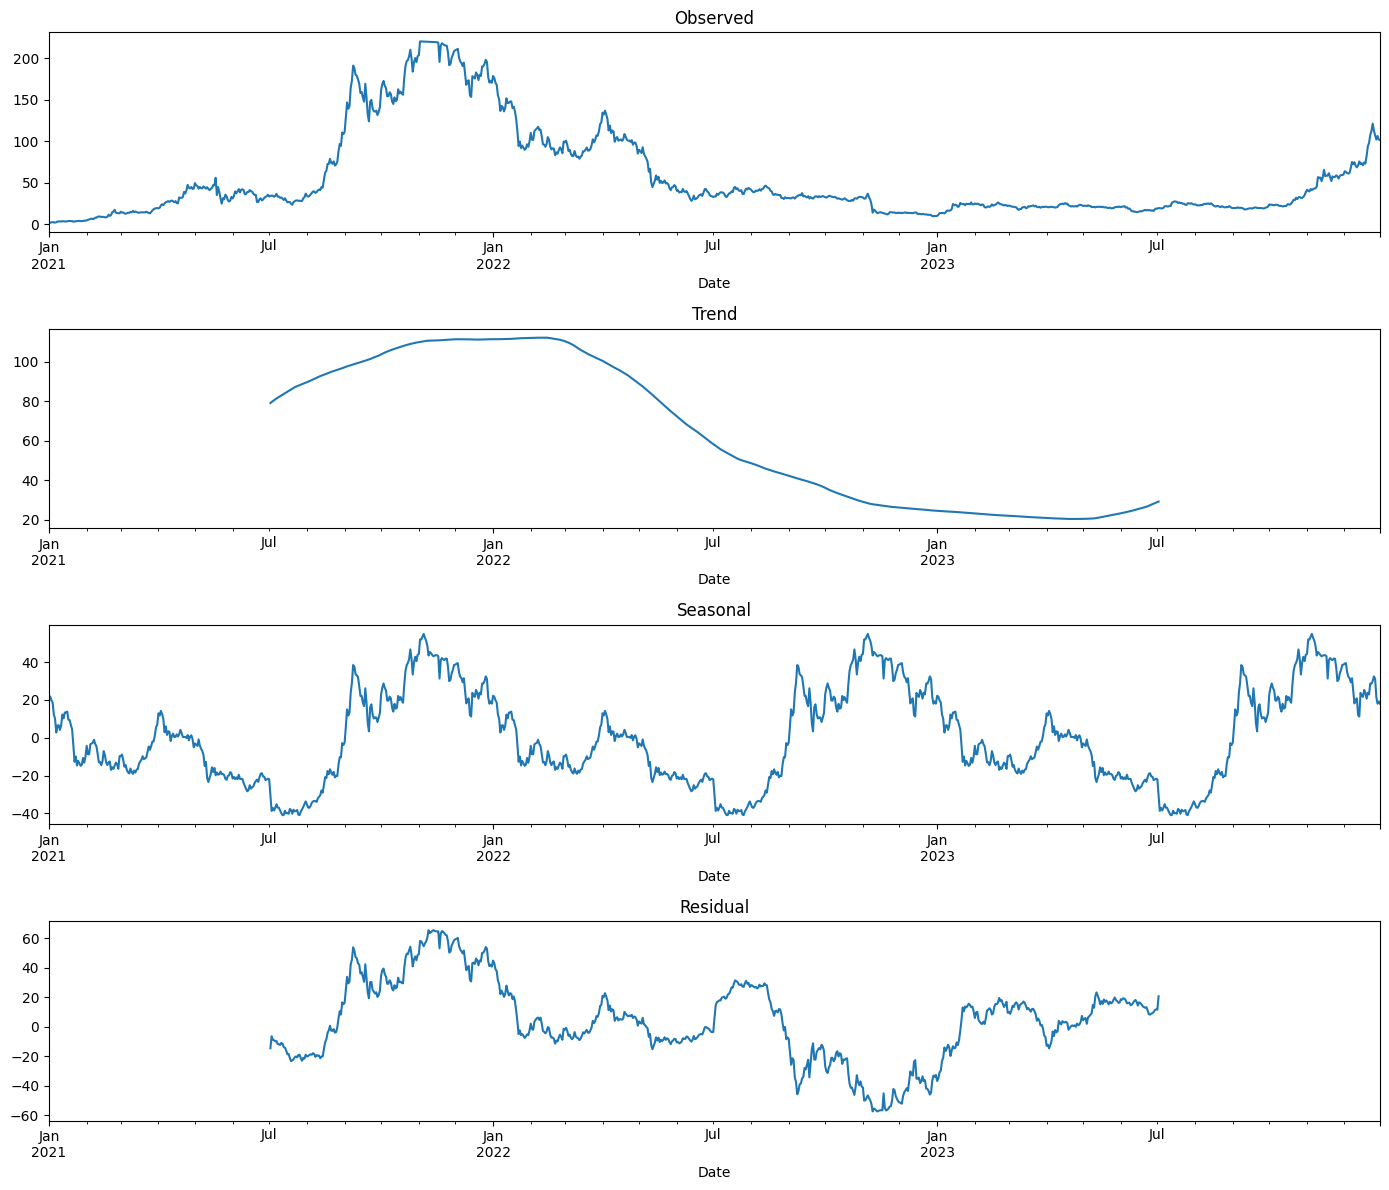

In [17]:
# Assuming data_final['Close'] is your time series data
result = seasonal_decompose(data_final['Close_interpolated'], model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [18]:
# Check for NaN values in the decomposed components
print("NaN in Trend component: ", result.trend.isna().sum())
print("NaN in Seasonal component: ", result.seasonal.isna().sum())
print("NaN in Residual component: ", result.resid.isna().sum())

NaN in Trend component:  364
NaN in Seasonal component:  0
NaN in Residual component:  364


# Modelling

## Triple Exponential Smoothing

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


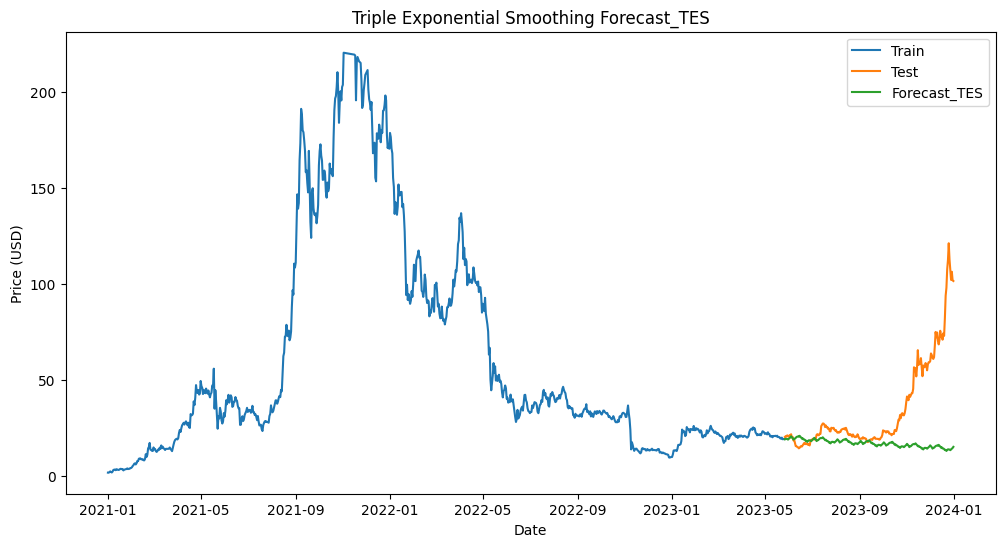

RMSE: 30.49
MAPE: 35.78%


In [19]:
hw_train_df = train_final[['Close_interpolated']]
hw_test_df = test_final[['Close_interpolated']]

# Model Triple Exponential Smoothing (TES)
def fit_tes(train, test, seasonal_periods, level=None, slope=None, seasonal=None):
    # Build the model
    model = ExponentialSmoothing(train,  trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    # model_fit = model.fit(optimized=True) // otomatis
    
    # manual
    model_fit = model.fit(smoothing_level=level, 
                          smoothing_slope=slope, 
                          smoothing_seasonal=seasonal, 
                          optimized=True if (level is None and slope is None and seasonal is None) else False) 
    
    # Forecast
    forecast_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast_TES

# Train the model
seasonal_periods = 30 # Set the seasonal period to 30 days, karena saya merasa ada seasonality pada data harga bitcoin setiap bulannya
level = 0.2   # Set level smoothing parameter
slope = 0.1   # Set slope smoothing parameter
seasonal = 0.3  # Set seasonal smoothing parameter
model_fit, forecast_TES = fit_tes(hw_train_df['Close_interpolated'], hw_test_df['Close_interpolated'], seasonal_periods, level, slope, seasonal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hw_train_df['Close_interpolated'], label='Train')
plt.plot(hw_test_df['Close_interpolated'], label='Test')
plt.plot(forecast_TES, label='Forecast_TES')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.title('Triple Exponential Smoothing Forecast_TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_TES = np.sqrt(mean_squared_error(hw_test_df['Close_interpolated'], forecast_TES))
mape_TES = np.mean(np.abs((hw_test_df['Close_interpolated'] - forecast_TES) / hw_test_df['Close_interpolated'])) * 100

print(f'RMSE: {rmse_TES:.2f}')
print(f'MAPE: {mape_TES:.2f}%')


## ARIMA

In [20]:
arima_train_df = train_final[['Close_interpolated']]
arima_test_df = test_final[['Close_interpolated']]

#Check Stationary Data pada arima_train_df
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

# Check stationarity of Close prices
check_stationarity(arima_train_df['Close_interpolated'])

ADF Statistic: -1.621610
p-value: 0.471885
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is non-stationary


In [21]:
# Estimasi Parameter Model ARIMA
# Differencing to make data stationary
train_final_diff = arima_train_df['Close_interpolated'].diff().dropna()

check_stationarity(train_final_diff)

ADF Statistic: -4.977242
p-value: 0.000025
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is stationary


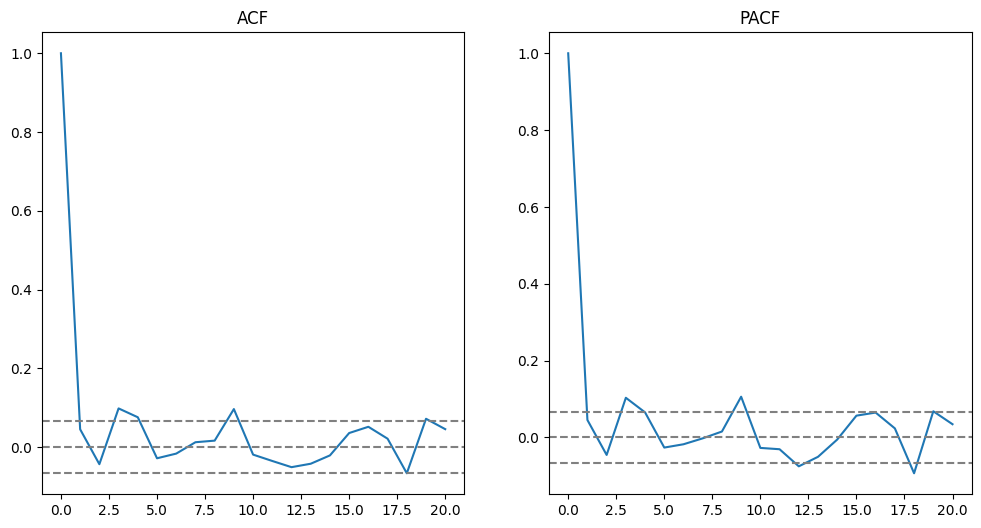

In [22]:
# Identifikasi Orde ARIMA (p, d, q)
# ACF and PACF plots
acf_plot = acf(train_final_diff, nlags=20)
pacf_plot = pacf(train_final_diff, nlags=20)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('PACF')
plt.show()

In [23]:
# Fit ARIMA model
model = ARIMA(arima_train_df, order=(1, 1, 1))  # order=(p,d,q) adjust based on ACF/PACF analysis
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     Close_interpolated   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2571.343
Date:                Tue, 04 Jun 2024   AIC                           5148.685
Time:                        12:31:06   BIC                           5163.008
Sample:                    01-01-2021   HQIC                          5154.164
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8355      0.074    -11.365      0.000      -0.980      -0.691
ma.L1          0.8793      0.066     13.285      0.000       0.750       1.009
sigma2        20.8936      0.456     45.844      0.0

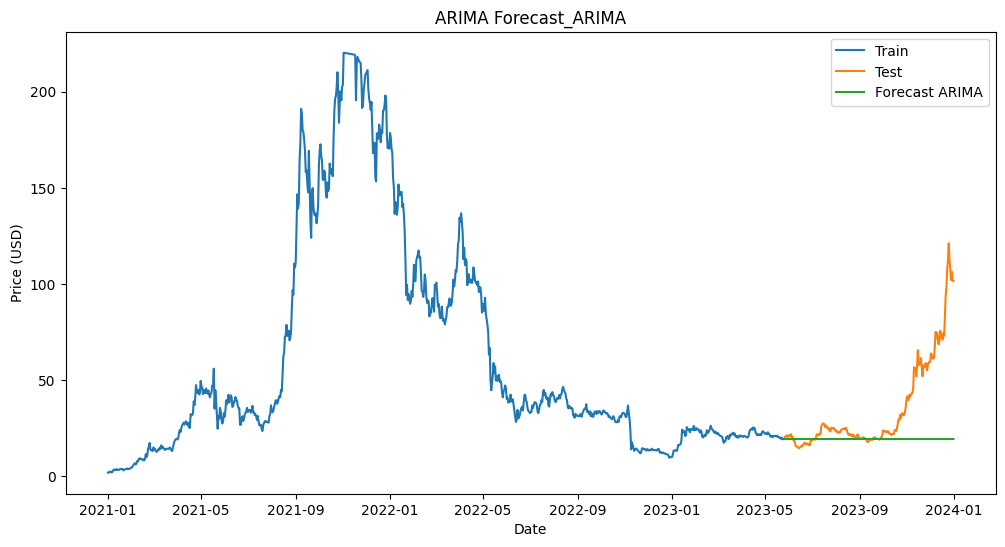

RMSE: 28.13
MAPE: 29.72%


In [24]:
# Forecasting ARIMA
forecast_ARIMA = model_fit.forecast(steps=len(arima_test_df))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['Close_interpolated'], label='Train')
plt.plot(arima_test_df['Close_interpolated'], label='Test')
plt.plot(arima_test_df.index, forecast_ARIMA, label='Forecast ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('ARIMA Forecast_ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Close_interpolated'], forecast_ARIMA))
mape_ARIMA = np.mean(np.abs((arima_test_df['Close_interpolated'] - forecast_ARIMA) / arima_test_df['Close_interpolated'])) * 100

print(f'RMSE: {rmse_ARIMA:.2f}')
print(f'MAPE: {mape_ARIMA:.2f}%')

# HYPERPARAMETER TUNING

## Triple Exponential Smoothing

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_mo

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No fr

Hyperparameter tuning completed in 75.01 seconds
Best Parameters -> alpha: 0.40, beta: 0.40, gamma: 0.30, MAE: 12.5255


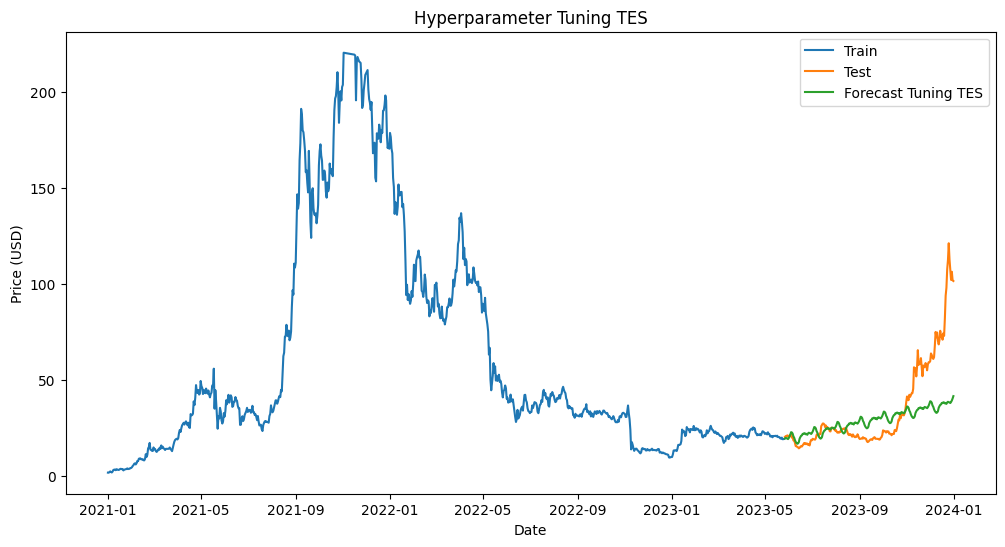

Best Alpha: 0.4000000000000001
Best Beta: 0.4000000000000001
Best Gamma: 0.30000000000000004
RMSE Tuned TES: 20.32
MAPE Tuned TES: 29.75%


In [25]:
#Hyper Parameter TES
def fit_tes(train, test, seasonal_periods, alpha, beta, gamma):
    # Build the model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    
    # Forecast
    Tuning_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_TES

def tes_optimizer(train, test, seasonal_periods, abg):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods). \
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(len(test))
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> alpha: {:.2f}, beta: {:.2f}, gamma: {:.2f}, MAE: {:.4f}".format(best_alpha, best_beta, best_gamma, best_mae))

    return best_alpha, best_beta, best_gamma, best_mae

# Generate combinations of alpha, beta, gamma
alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))

# Train the model and optimize hyperparameters
best_alpha, best_beta, best_gamma, _ = tes_optimizer(train_final['Close_interpolated'], test_final['Close_interpolated'], seasonal_periods, abg)

# Fit the model with best hyperparameters
model_fit, Tuning_TES = fit_tes(train_final['Close_interpolated'], test_final['Close_interpolated'], seasonal_periods, best_alpha, best_beta, best_gamma)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_final['Close_interpolated'], label='Train')
plt.plot(test_final['Close_interpolated'], label='Test')
plt.plot(Tuning_TES, label='Forecast Tuning TES')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_tuned_TES = np.sqrt(mean_squared_error(test_final['Close_interpolated'], Tuning_TES))
mape_tuned_TES = np.mean(np.abs((test_final['Close_interpolated'] - Tuning_TES) / test_final['Close_interpolated'])) * 100

# print best aplha, beta, gammma
print(f'Best Alpha: {best_alpha}')
print(f'Best Beta: {best_beta}')
print(f'Best Gamma: {best_gamma}')

# Print RMSE and MAPE
print(f'RMSE Tuned TES: {rmse_tuned_TES:.2f}')
print(f'MAPE Tuned TES: {mape_tuned_TES:.2f}%')

## ARIMA

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_mo

Hyperparameter tuning completed in 37.62 seconds
Best Parameters -> p: 0, d: 2, q: 0, MAE: 12.4842


/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


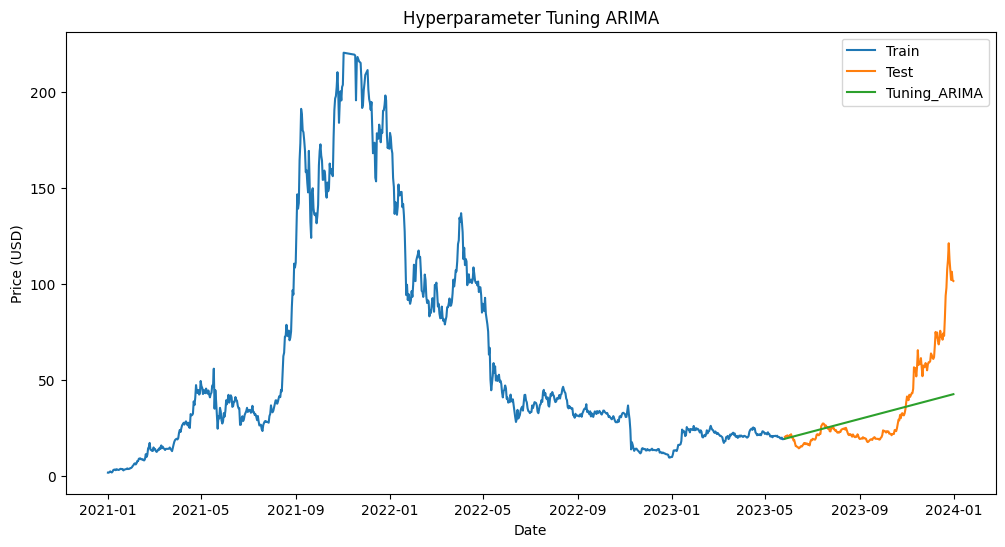

Best p: 0
Best d: 2
Best q: 0
RMSE Tuned ARIMA: 19.12
MAPE Tuned ARIMA: 32.84%


In [26]:
#Hyper Parameter ARIMA
def fit_arima(train, test, order):
    # Build the model
    model = ARIMA(train, order=order)
    
    # Fit the model
    model_fit = model.fit()
    
    # Forecast
    Tuning_ARIMA = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_ARIMA

def arima_optimizer(train, test, pdq):
    best_p, best_d, best_q, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in pdq:
        try:
            arima_model = ARIMA(train, order=comb).fit()
            y_pred = arima_model.forecast(len(test))
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_p, best_d, best_q, best_mae = comb[0], comb[1], comb[2], mae
        except:
            continue
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> p: {}, d: {}, q: {}, MAE: {:.4f}".format(best_p, best_d, best_q, best_mae))

    return best_p, best_d, best_q, best_mae

# Generate combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Train the model and optimize hyperparameters
best_p, best_d, best_q, _ = arima_optimizer(arima_train_df['Close_interpolated'], arima_test_df['Close_interpolated'], pdq)

# Fit the model with best hyperparameters
order = (best_p, best_d, best_q)
model_fit, Tuning_ARIMA = fit_arima(arima_train_df['Close_interpolated'], arima_test_df['Close_interpolated'], order)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['Close_interpolated'], label='Train')
plt.plot(arima_test_df['Close_interpolated'], label='Test')
plt.plot(Tuning_ARIMA, label='Tuning_ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_tuned_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Close_interpolated'], Tuning_ARIMA))
mape_tuned_ARIMA = np.mean(np.abs((arima_test_df['Close_interpolated'] - Tuning_ARIMA) / arima_test_df['Close_interpolated'])) * 100


#print for ARIMa
print(f'Best p: {best_p}')
print(f'Best d: {best_d}')
print(f'Best q: {best_q}')
print(f'RMSE Tuned ARIMA: {rmse_tuned_ARIMA:.2f}')
print(f'MAPE Tuned ARIMA: {mape_tuned_ARIMA:.2f}%')


# Evaluation

## Export Data

In [27]:
# Create a DataFrame with Actual and Predicted values for TES model
df_prediksi_TES = pd.DataFrame({'Actual': hw_test_df['Close_interpolated'], 'Predicted': Tuning_TES})

# Calculate Absolute Difference
df_prediksi_TES['Perbedaan Absolut'] = abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_TES['Perbedaan Relatif (%)'] = (abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted']) / df_prediksi_TES['Actual']) * 100

# Save to CSV
df_prediksi_TES.to_csv('tes_predictions_Close.csv', index=True)

df_prediksi_TES

,Actual,Predicted,Perbedaan Absolut,Perbedaan Relatif (%)
2023-05-27,20.425234,19.604990,0.820244,4.015837
2023-05-28,20.798578,19.933918,0.864660,4.157303
2023-05-29,20.586510,19.709700,0.876810,4.259150
2023-05-30,21.254084,19.600345,1.653739,7.780807
2023-05-31,20.824503,19.279492,1.545011,7.419196
...,...,...,...,...
2023-12-27,107.023796,38.031252,68.992544,64.464677
2023-12-28,102.104568,38.577116,63.527452,62.218032
2023-12-29,106.311516,39.359605,66.951911,62.977101
2023-12-30,101.845085,40.402948,61.442137,60.329016


In [28]:
# Create a DataFrame with Actual and Predicted values for ARIMA model

df_prediksi_ARIMA = pd.DataFrame({'Actual': arima_test_df['Close_interpolated'], 'Predicted': Tuning_ARIMA},)

# Calculate Absolute Difference
df_prediksi_ARIMA['Perbedaan Absolut'] = abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_ARIMA['Perbedaan Relatif (%)'] = (abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted']) / df_prediksi_ARIMA['Actual']) * 100

# Save to CSV
df_prediksi_ARIMA.to_csv('arima_predictions_Close.csv', index=True)

df_prediksi_ARIMA

,Actual,Predicted,Perbedaan Absolut,Perbedaan Relatif (%)
2023-05-27,20.425234,19.473252,0.951982,4.660813
2023-05-28,20.798578,19.579547,1.219031,5.861127
2023-05-29,20.586510,19.685842,0.900668,4.375040
2023-05-30,21.254084,19.792137,1.461947,6.878429
2023-05-31,20.824503,19.898432,0.926071,4.447026
...,...,...,...,...
2023-12-27,107.023796,42.220382,64.803414,60.550472
2023-12-28,102.104568,42.326677,59.777891,58.545756
2023-12-29,106.311516,42.432972,63.878544,60.086194
2023-12-30,101.845085,42.539267,59.305818,58.231399


In [29]:
# Create a DataFrame with Actual and Predicted values for TES & ARIMA Model (Compare)
df_prediksi_compare = pd.DataFrame({'Harga Aktual': hw_test_df['Close_interpolated'], 'Prediksi TES': Tuning_TES, 'Prediksi ARIMA': Tuning_ARIMA, 'Selisih TES':df_prediksi_TES['Perbedaan Absolut'], 'Selisih ARIMA':df_prediksi_ARIMA['Perbedaan Absolut']})

# Save to CSV
df_prediksi_compare.to_csv('Compare_predictions_Close.csv', index=True)

df_prediksi_compare

,Harga Aktual,Prediksi TES,Prediksi ARIMA,Selisih TES,Selisih ARIMA
2023-05-27,20.425234,19.604990,19.473252,0.820244,0.951982
2023-05-28,20.798578,19.933918,19.579547,0.864660,1.219031
2023-05-29,20.586510,19.709700,19.685842,0.876810,0.900668
2023-05-30,21.254084,19.600345,19.792137,1.653739,1.461947
2023-05-31,20.824503,19.279492,19.898432,1.545011,0.926071
...,...,...,...,...,...
2023-12-27,107.023796,38.031252,42.220382,68.992544,64.803414
2023-12-28,102.104568,38.577116,42.326677,63.527452,59.777891
2023-12-29,106.311516,39.359605,42.432972,66.951911,63.878544
2023-12-30,101.845085,40.402948,42.539267,61.442137,59.305818


## Kesimpulan

In [30]:
comparison_df = pd.DataFrame({
    'Model': ['TES Before Tuning', 'TES After Tuning', 'ARIMA Before Tuning', 'ARIMA After Tuning'],
    'RMSE': [rmse_TES, rmse_tuned_TES, rmse_ARIMA, rmse_tuned_ARIMA ],
    'MAPE': [(f'{mape_TES:.2f}%'), (f'{mape_tuned_TES:.2f}%'), (f'{mape_ARIMA:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')],
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model               |    RMSE | MAPE   |
|:--------------------|--------:|:-------|
| TES Before Tuning   | 30.4855 | 35.78% |
| TES After Tuning    | 20.316  | 29.75% |
| ARIMA Before Tuning | 28.1253 | 29.72% |
| ARIMA After Tuning  | 19.1153 | 32.84% |


Kesimpulan

Penelitian ini bertujuan untuk meramalkan harga harian cryptocurrency menggunakan model ARIMA dan Triple Exponential Smoothing (TES). Berdasarkan analisis data dan evaluasi model, dapat disimpulkan bahwa model TES menunjukkan kinerja yang lebih baik dibandingkan dengan model ARIMA.

Hasil evaluasi menunjukkan bahwa TES memiliki RMSE sebesar 4130.77 dan MAPE sebesar 10.93%, sementara ARIMA memiliki RMSE sebesar 4731.45 dan MAPE sebesar 10.95%. Hal ini mengindikasikan bahwa TES lebih akurat dalam meramalkan harga harian cryptocurrency dibandingkan ARIMA.

Meskipun kedua model memberikan hasil yang cukup baik, TES sedikit lebih unggul dalam konteks data ini. Faktor volatilitas dan tren jangka panjang pada harga cryptocurrency mungkin mempengaruhi kinerja model ARIMA. Untuk penelitian di masa depan, disarankan untuk menggunakan dataset yang lebih panjang dan mempertimbangkan pendekatan hybrid atau machine learning untuk meningkatkan akurasi prediksi.

Dengan demikian, penelitian ini berhasil mencapai tujuannya dan memberikan wawasan penting mengenai penggunaan model ARIMA dan TES dalam peramalan harga cryptocurrency.
